In [1]:
import pandas as pd
import main as main
import numpy as np
import holidays
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('BikeSharing_Bluebikes2022.csv', index_col=0)

/home/georgep/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,597,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,178,MIT Pacific St at Purrington St,42.359573,-71.101295,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923,Subscriber,02139
1,411,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,3112,Subscriber,02139
2,476,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,6901,Customer,02124
3,466,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,5214,Customer,02124
4,752,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,19,Park Dr at Buswell St,42.347241,-71.105301,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214,Subscriber,02215


In [5]:
#transforming the dates from object to datetime
for date_column in ['starttime','stoptime']:
    data[date_column] = pd.to_datetime(data[date_column], format='%Y-%m-%d %H:%M:%S')

## Prediction challenge 

In [13]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df15 = main.DatetimeInterval(data, freq='15Min')
df30 = main.DatetimeInterval(data, freq='30Min')
df60 = main.DatetimeInterval(data, freq='60Min')
df120 = main.DatetimeInterval(data, freq='120Min')
picks15 = main.Lagging(df15, 15)
picks30 = main.Lagging(df30, 30).dropna()
picks60 = main.Lagging(df60, 60).dropna()
picks120 = main.Lagging(df120, 120).dropna()

In [15]:
def ModelRunningResults(models,models_name, first_row, picks):
    results = {}
    table = [first_row]
    pipe = main.PredictionPipeline(picks)
    X_train, X_test, y_train, y_test = pipe.PredictionDataPreperation()
    for model, model_name in zip(models,models_name):
        CV_score, CV_MSE, test_score, test_MSE = pipe.BackTestingPrediction(model, model_name, X_train, X_test, y_train, y_test)
        results[model_name] = {'Cross Validation Score': CV_score, 'Cross Validation MSE': CV_MSE, 'Test Score':test_score, 'Test MSE':test_MSE}
        row = [model_name, np.max(CV_score), np.min(CV_MSE), test_score, test_MSE]
        table.append(row)      

    return table

In [17]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model','OptimalCrossValScore','OptimalCrossValMSE','OptimalTestScore','OptimalTestMSE']
print(tabulate(ModelRunningResults(models,models_name, first_row, picks15),headers='firstrow',colalign=("left",), floatfmt=".4f"))

Model                    OptimalCrossValScore    OptimalCrossValMSE    OptimalTestScore    OptimalTestMSE
---------------------  ----------------------  --------------------  ------------------  ----------------
LinearRegression                       0.7542               20.0990              0.7475           64.2114
RidgeRegression                        0.7534               20.1318              0.7474           64.2137
LassoRegression                        0.7314               21.7416              0.7367           65.5662
RandomForestRegressor                  0.9119               18.1884              0.8522           49.1185
ExtraTreesRegressor                    0.9190               18.6675              0.8624           47.3944


### Weather Data

In [8]:
weather_data = pd.read_csv('Data/WeatherData', index_col=0)

In [9]:
weather_data.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,Boston,2022-01-01T00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,...,1014.5,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
1,Boston,2022-01-01T01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,...,1014.1,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2,Boston,2022-01-01T02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,...,1014.2,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
3,Boston,2022-01-01T03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,...,1014.1,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
4,Boston,2022-01-01T04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,...,1013.6,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."


In [10]:
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], format='%Y-%m-%dT%H:%M:%S')
weather_data.drop('name',axis=1, inplace=True)
weather_data.set_index('datetime', inplace=True)

In [11]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,1014.5,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.2,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,1013.6,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."


In [12]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5831 entries, 2022-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              5831 non-null   float64
 1   feelslike         5831 non-null   float64
 2   dew               5831 non-null   float64
 3   humidity          5831 non-null   float64
 4   precip            5831 non-null   float64
 5   precipprob        5831 non-null   int64  
 6   preciptype        547 non-null    object 
 7   snow              5831 non-null   float64
 8   snowdepth         5831 non-null   float64
 9   windgust          5675 non-null   float64
 10  windspeed         5831 non-null   float64
 11  winddir           5831 non-null   float64
 12  sealevelpressure  5831 non-null   float64
 13  cloudcover        5831 non-null   float64
 14  visibility        5831 non-null   float64
 15  solarradiation    5691 non-null   float64
 16  solare

In [13]:
weather_data.isna().sum()

temp                   0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
preciptype          5284
snow                   0
snowdepth              0
windgust             156
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation       140
solarenergy         2547
uvindex              140
severerisk           230
conditions             0
icon                   0
stations               0
dtype: int64

In [14]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,1014.5,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,1014.2,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,1014.1,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,1013.6,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591..."


temp

In [15]:
weather_data['temp'].describe()

count    5831.000000
mean       12.352478
std        11.056270
min       -15.600000
25%         4.300000
50%        12.900000
75%        21.600000
max        37.200000
Name: temp, dtype: float64

feelslike

In [16]:
weather_data['feelslike'].describe()

count    5831.000000
mean       10.596210
std        13.410548
min       -26.500000
25%         0.800000
50%        12.900000
75%        21.600000
max        39.500000
Name: feelslike, dtype: float64

Humidity

In [17]:
weather_data['humidity'].describe()

count    5831.000000
mean       62.503353
std        20.229678
min        15.130000
25%        46.120000
50%        61.270000
75%        79.645000
max        99.940000
Name: humidity, dtype: float64

precip

In [18]:
weather_data['precip'].describe()

count    5831.000000
mean        0.077047
std         0.451573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.546000
Name: precip, dtype: float64

In [19]:
weather_data[weather_data['precip']>0]['conditions'].unique()

array(['Rain, Overcast', 'Snow, Rain, Overcast', 'Snow, Overcast',
       'Rain, Partially cloudy', 'Snow, Ice, Overcast',
       'Snow, Partially cloudy'], dtype=object)

snow

In [20]:
weather_data['snow'].describe()

count    5831.000000
mean        0.019317
std         0.142421
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.600000
Name: snow, dtype: float64

In [21]:
weather_data[weather_data['snow']>2]['conditions'].unique()

array(['Partially cloudy'], dtype=object)

Preciptype

In [22]:
weather_data['preciptype'].nunique()

5

In [23]:
weather_data['preciptype'].unique()

array([nan, 'rain', 'rain,snow', 'snow', 'freezingrain', 'snow,ice'],
      dtype=object)

In [24]:
weather_data[weather_data['preciptype']=='snow'][['snow','snowdepth']]

,snow,snowdepth
datetime,,
2022-01-07 05:00:00,1.04,21.88
2022-01-24 00:00:00,0.00,0.10
2022-01-25 00:00:00,0.13,2.00
2022-01-25 01:00:00,0.13,2.13
2022-01-29 02:00:00,0.42,7.50
...,...,...
2022-03-03 03:00:00,0.70,13.42
2022-03-03 04:00:00,1.10,13.33
2022-03-03 05:00:00,0.40,13.25


In [25]:
weather_data['enc_preciptype'] = weather_data['preciptype'].map(lambda row: main.PreciptypeMap(row))

In [26]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,enc_preciptype
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,100.0,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,100.0,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,100.0,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,100.0,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,100.0,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0


Conditions

In [27]:
weather_data['conditions'].unique()

array(['Overcast', 'Rain, Overcast', 'Partially cloudy', 'Clear',
       'Snow, Rain, Overcast', 'Snow, Overcast', 'Rain, Partially cloudy',
       'Snow, Ice, Overcast', 'Snow, Partially cloudy'], dtype=object)

In [28]:
weather_data['enc_conditions'] = weather_data['conditions'].map(lambda row: main.ConditionsMap(row))

In [29]:
weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,...,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,enc_preciptype,enc_conditions
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,6.7,92.50,0.0,0,NaN,0.0,0.0,NaN,...,8.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 01:00:00,7.2,6.5,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,5.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 02:00:00,7.2,6.0,6.7,96.49,0.0,0,NaN,0.0,0.0,NaN,...,4.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 03:00:00,7.2,7.2,6.7,96.60,0.0,0,NaN,0.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1
2022-01-01 04:00:00,6.8,5.4,6.7,99.79,0.0,0,NaN,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,Overcast,cloudy,"KOWD,72509854704,KBED,KBOS,72509014739,7250591...",0,1


Severerisk

In [30]:
weather_data['severerisk'].unique()

array([nan, 10.,  3.,  5., 30., 15.,  8., 60., 75.])

In [31]:
weather_data['severerisk'].fillna(weather_data['severerisk'].median(), inplace=True)

solar radiation

In [32]:
weather_data['solarradiation'].unique()

array([      nan, 1.100e+01, 2.400e+01, 2.100e+01, 2.600e+01, 2.700e+01,
       4.500e+01, 3.200e+01, 1.200e+01, 7.000e+00, 2.500e+01, 3.600e+01,
       7.000e+01, 8.200e+01, 4.300e+01, 5.000e+01, 3.000e+01, 9.000e+00,
       5.200e+01, 6.400e+01, 7.400e+01, 6.800e+01, 4.000e+01, 3.900e+01,
       1.800e+01, 2.300e+01, 1.540e+02, 2.750e+02, 3.530e+02, 3.800e+02,
       3.660e+02, 3.010e+02, 2.360e+02, 1.600e+01, 5.000e+00, 3.700e+01,
       1.050e+02, 1.110e+02, 7.500e+01, 5.600e+01, 7.200e+01, 4.400e+01,
       1.500e+01, 2.580e+02, 3.190e+02, 2.220e+02, 1.970e+02, 1.990e+02,
       1.270e+02, 2.000e+01, 1.000e+01, 3.500e+01, 5.300e+01, 1.450e+02,
       9.800e+01, 6.700e+01, 1.350e+02, 2.820e+02, 3.630e+02, 3.950e+02,
       3.810e+02, 2.720e+02, 1.860e+02, 1.700e+01, 2.900e+01, 5.700e+01,
       1.920e+02, 1.520e+02, 9.200e+01, 1.340e+02, 2.860e+02, 3.960e+02,
       4.010e+02, 3.990e+02, 3.150e+02, 1.480e+02, 3.300e+01, 0.000e+00,
       1.330e+02, 3.170e+02, 3.670e+02, 3.790e+02, 

In [33]:
weather_data['solarradiation'].min()

0.0

In [34]:
#weather_data[weather_data['solarradiation'].isna()==True]
weather_data[weather_data['solarradiation']==0.0]['severerisk'].unique()

array([10.,  3.,  5., 15., 30., 60.,  8.])

In [35]:
weather_data[weather_data['solarradiation']==0.0]['enc_conditions'].unique()

array([1, 2, 3])

In [36]:
weather_data[weather_data['solarradiation'].isna()==True]['severerisk'].unique()

array([10.])

In [37]:
sorted(weather_data[weather_data['solarradiation'].isna()==True].index)

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-01 01:00:00'),
 Timestamp('2022-01-01 02:00:00'),
 Timestamp('2022-01-01 03:00:00'),
 Timestamp('2022-01-01 04:00:00'),
 Timestamp('2022-01-01 05:00:00'),
 Timestamp('2022-01-01 06:00:00'),
 Timestamp('2022-01-01 07:00:00'),
 Timestamp('2022-01-01 17:00:00'),
 Timestamp('2022-01-01 18:00:00'),
 Timestamp('2022-01-01 19:00:00'),
 Timestamp('2022-01-01 20:00:00'),
 Timestamp('2022-01-01 21:00:00'),
 Timestamp('2022-01-01 22:00:00'),
 Timestamp('2022-01-01 23:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-02 01:00:00'),
 Timestamp('2022-01-02 02:00:00'),
 Timestamp('2022-01-02 03:00:00'),
 Timestamp('2022-01-02 04:00:00'),
 Timestamp('2022-01-02 05:00:00'),
 Timestamp('2022-01-02 06:00:00'),
 Timestamp('2022-01-02 07:00:00'),
 Timestamp('2022-01-02 17:00:00'),
 Timestamp('2022-01-02 18:00:00'),
 Timestamp('2022-01-02 19:00:00'),
 Timestamp('2022-01-02 20:00:00'),
 Timestamp('2022-01-02 21:00:00'),
 Timestamp('2022-01-

In [38]:
weather_data['solarradiation'].fillna(0.0, inplace=True)

UVindex

In [39]:
weather_data['uvindex'].unique()

array([nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [40]:
sorted(weather_data[weather_data['uvindex'].isna()==True].index)

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-01 01:00:00'),
 Timestamp('2022-01-01 02:00:00'),
 Timestamp('2022-01-01 03:00:00'),
 Timestamp('2022-01-01 04:00:00'),
 Timestamp('2022-01-01 05:00:00'),
 Timestamp('2022-01-01 06:00:00'),
 Timestamp('2022-01-01 07:00:00'),
 Timestamp('2022-01-01 17:00:00'),
 Timestamp('2022-01-01 18:00:00'),
 Timestamp('2022-01-01 19:00:00'),
 Timestamp('2022-01-01 20:00:00'),
 Timestamp('2022-01-01 21:00:00'),
 Timestamp('2022-01-01 22:00:00'),
 Timestamp('2022-01-01 23:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-02 01:00:00'),
 Timestamp('2022-01-02 02:00:00'),
 Timestamp('2022-01-02 03:00:00'),
 Timestamp('2022-01-02 04:00:00'),
 Timestamp('2022-01-02 05:00:00'),
 Timestamp('2022-01-02 06:00:00'),
 Timestamp('2022-01-02 07:00:00'),
 Timestamp('2022-01-02 17:00:00'),
 Timestamp('2022-01-02 18:00:00'),
 Timestamp('2022-01-02 19:00:00'),
 Timestamp('2022-01-02 20:00:00'),
 Timestamp('2022-01-02 21:00:00'),
 Timestamp('2022-01-

In [41]:
weather_data['uvindex'].fillna(0.0, inplace=True)

In [42]:
weather_data.drop(['dew','sealevelpressure','cloudcover','solarenergy','icon','windgust','winddir','solarradiation','precipprob','conditions','preciptype','stations'], axis=1, inplace=True)

In [43]:
weather_data.head()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,enc_preciptype,enc_conditions
datetime,,,,,,,,,,,,
2022-01-01 00:00:00,7.8,7.8,92.50,0.0,0.0,0.0,0.1,8.0,0.0,10.0,0,1
2022-01-01 01:00:00,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,0,1
2022-01-01 02:00:00,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,0,1
2022-01-01 03:00:00,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,0,1
2022-01-01 04:00:00,6.8,5.4,99.79,0.0,0.0,0.0,7.4,0.0,0.0,10.0,0,1


In [44]:
weather_data15 = weather_data.resample('15Min').fillna(method='ffill')
weather_data30 = weather_data.resample('20Min').fillna(method='ffill')
weather_data60 = weather_data
weather_data120 = weather_data.resample('2H').mean()

# Connect Data

In [45]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [46]:
df15 = main.DatetimeInterval(data, freq='15Min')
df30 = main.DatetimeInterval(data, freq='30Min')
df60 = main.DatetimeInterval(data, freq='60Min')
df120 = main.DatetimeInterval(data, freq='120Min')

In [47]:
weather_data15 = weather_data.resample('15Min').fillna(method='ffill')
weather_data30 = weather_data.resample('30Min').fillna(method='ffill')
weather_data60 = weather_data
weather_data120 = weather_data.resample('2H').mean()

In [48]:
picksup15 = main.MergingDataFrames(weather_data15, df15)
picksup30 = main.MergingDataFrames(weather_data30, df30)
picksup60 = main.MergingDataFrames(weather_data60, df60)
picksup120 = main.MergingDataFrames(weather_data120, df120)

Weekend/Weekday & Holidays & Month/Hour/Minute & Season

In [49]:
season_month =  {1:'Winter', 2:'Winter',
                3:'Spring', 4:'Spring', 5:'Spring',
                6:'Summer', 7:'Summer', 8:'Summer'}

In [50]:
for pickup in [picksup15,picksup30, picksup60, picksup120]:
    pickup = main.DataPreprocess(pickup, season_month)
    pickup = pd.get_dummies(pickup, 'season')

In [51]:
weather_columns = [
       'temp', 'feelslike', 'humidity', 
       'precip', 'snow', 'snowdepth',
       'windspeed', 'visibility', 'uvindex', 
       'severerisk', 'enc_preciptype', 'enc_conditions'
        ]

In [52]:
picksup15 = pd.get_dummies(picksup15, 'season')
picksup30 = pd.get_dummies(picksup30, 'season')
picksup60 = pd.get_dummies(picksup60, 'season')
picksup120 = pd.get_dummies(picksup120, 'season')
picksup15 = main.Lagging(picksup15, 15, weather_columns)
picksup30 = main.Lagging(picksup30, 30, weather_columns)
picksup60 = main.Lagging(picksup60, 60, weather_columns)
picksup120 = main.Lagging(picksup120, 120, weather_columns)

# EDA 

In [98]:
picksup = picksup30.copy()

In [99]:
picksup.dropna(inplace=True)

In [100]:
picksup.head()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,0,0,0,1,59.0,66.0
5,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,30,0,0,1,43.0,59.0
6,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,0,0,0,1,49.0,43.0
7,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,30,0,0,1,41.0,49.0
8,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,0,1,1,4,0,0,0,1,32.0,41.0


In [101]:
picksup.describe()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
count,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,...,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000,11659.000000
mean,12.347663,10.589347,62.502053,0.077067,0.019322,2.161700,17.799580,14.869886,1.339738,10.827858,...,0.712154,0.028476,4.527661,11.502788,14.998713,0.378763,0.378677,0.242559,197.443005,197.346256
std,11.057928,13.413959,20.225247,0.451610,0.142433,5.760949,8.719053,3.543898,2.045488,6.627904,...,0.452779,0.166335,2.295053,6.920143,15.000643,0.485100,0.485078,0.428649,195.815357,195.601478
min,-15.600000,-26.500000,15.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000,0.800000,46.130000,0.000000,0.000000,0.000000,11.200000,16.000000,0.000000,10.000000,...,0.000000,0.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,34.000000,34.000000
50%,12.900000,12.900000,61.270000,0.000000,0.000000,0.000000,16.500000,16.000000,0.000000,10.000000,...,1.000000,0.000000,5.000000,12.000000,0.000000,0.000000,0.000000,0.000000,137.000000,137.000000
75%,21.600000,21.600000,79.640000,0.000000,0.000000,0.000000,23.700000,16.000000,2.000000,10.000000,...,1.000000,0.000000,7.000000,17.500000,30.000000,1.000000,1.000000,0.000000,303.000000,303.000000
max,37.200000,39.500000,99.940000,10.546000,6.600000,36.000000,64.000000,16.000000,10.000000,75.000000,...,1.000000,1.000000,8.000000,23.000000,30.000000,1.000000,1.000000,1.000000,1225.000000,1225.000000


<AxesSubplot:>

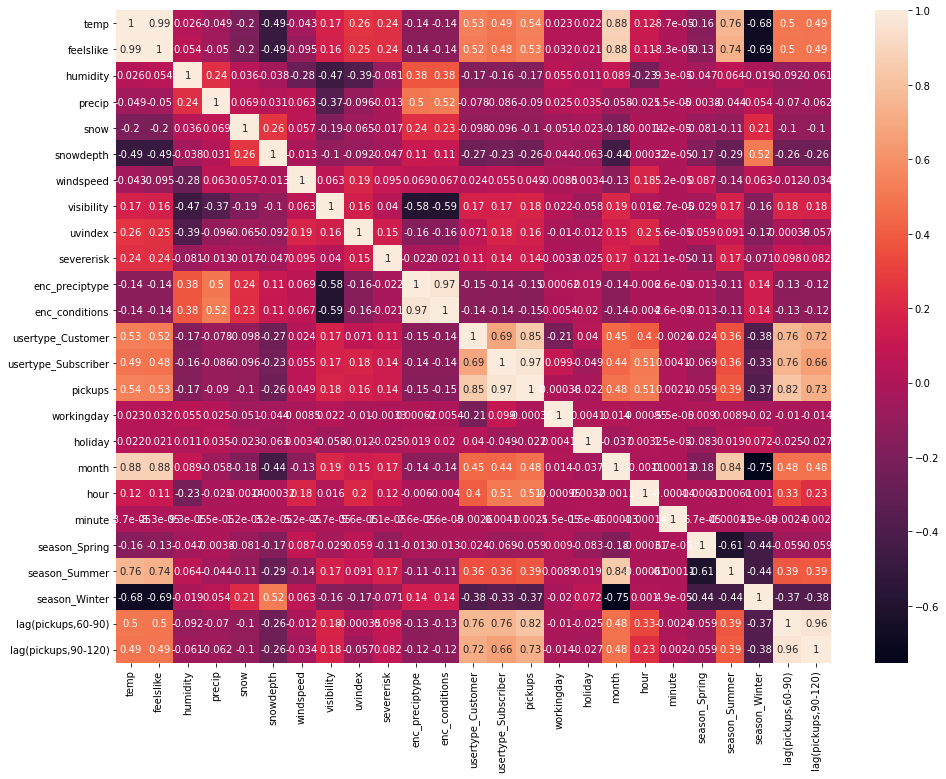

In [102]:
plt.figure(figsize=(16,12))
sns.heatmap(picksup.corr(), annot=True)

In [103]:
picksup.head(10)

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,0,0,0,1,59.0,66.0
5,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,30,0,0,1,43.0,59.0
6,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,0,0,0,1,49.0,43.0
7,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,30,0,0,1,41.0,49.0
8,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,0,1,1,4,0,0,0,1,32.0,41.0
9,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,0,1,1,4,30,0,0,1,42.0,32.0
10,6.8,5.4,99.79,0.0,0.0,0.0,7.4,0.0,0.0,10.0,...,0,1,1,5,0,0,0,1,53.0,42.0
11,6.8,5.4,99.79,0.0,0.0,0.0,7.4,0.0,0.0,10.0,...,0,1,1,5,30,0,0,1,40.0,53.0
12,6.8,5.0,99.85,0.0,0.0,0.0,9.0,0.0,0.0,10.0,...,0,1,1,6,0,0,0,1,51.0,40.0
13,6.8,5.0,99.85,0.0,0.0,0.0,9.0,0.0,0.0,10.0,...,0,1,1,6,30,0,0,1,42.0,51.0


/home/georgep/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pickups', ylabel='Density'>

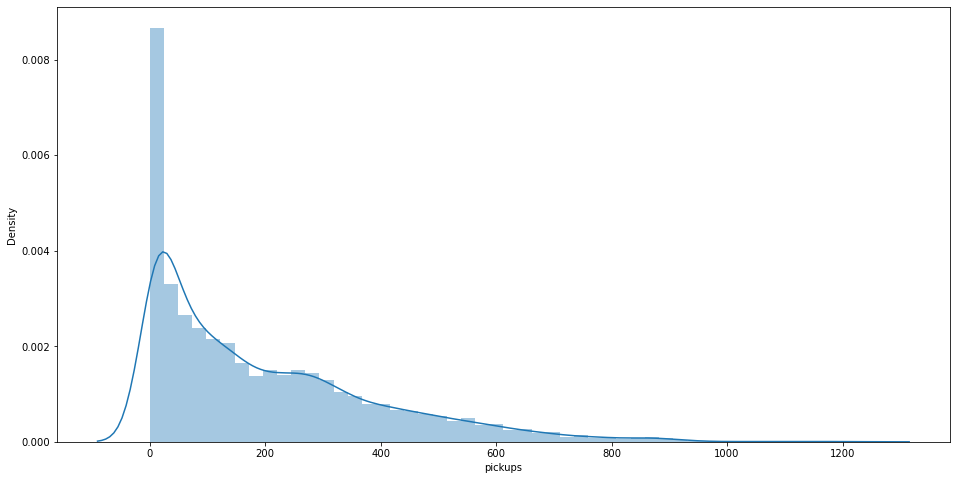

In [104]:
plt.figure(figsize=(16,8))
sns.distplot(picksup['pickups'])

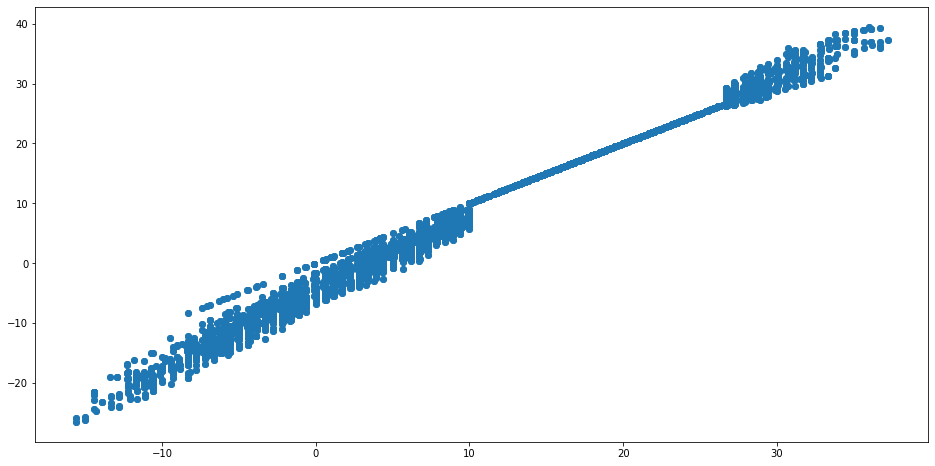

In [105]:
plt.figure(figsize=(16,8))
plt.scatter(picksup['temp'],picksup['feelslike'])

In [106]:
def scatter_plot():
    for i in picksup.columns:
        plt.scatter(picksup[i],picksup['pickups'])
        plt.title(f"Scatter plot for {i}")
        plt.show()

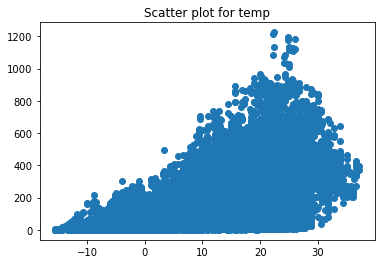

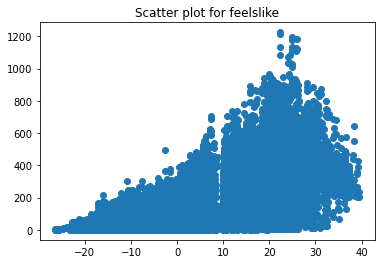

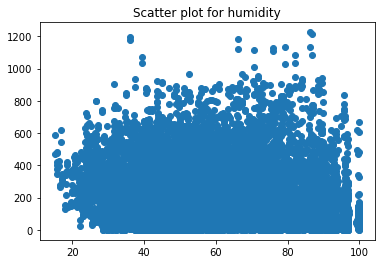

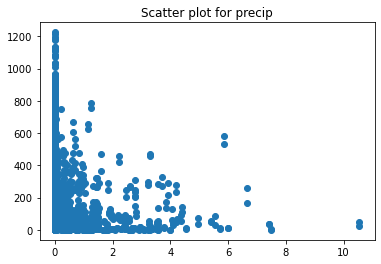

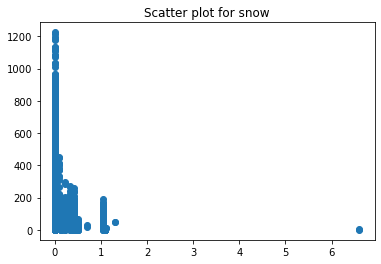

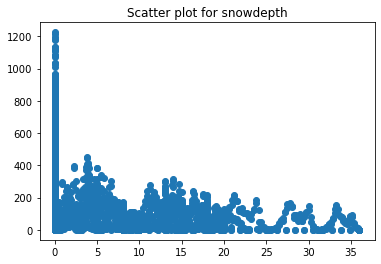

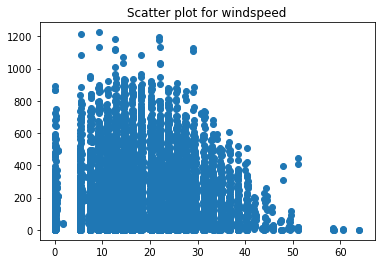

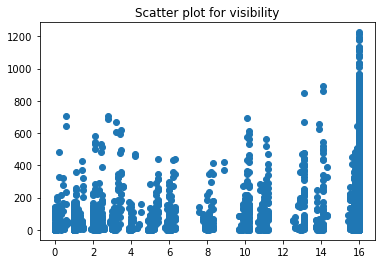

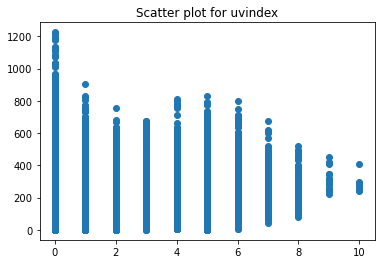

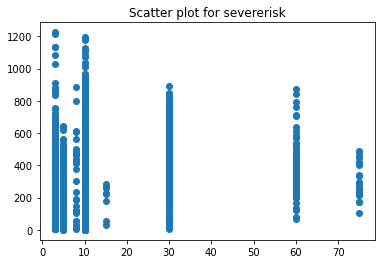

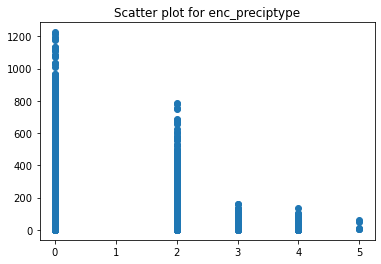

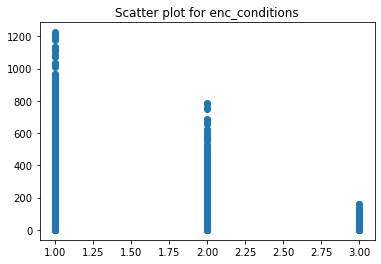

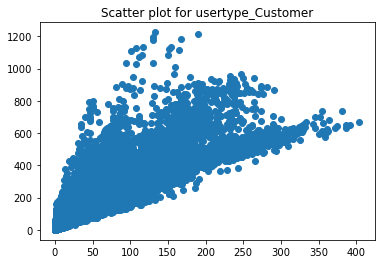

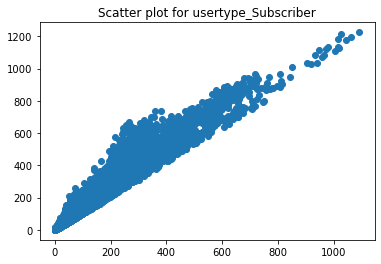

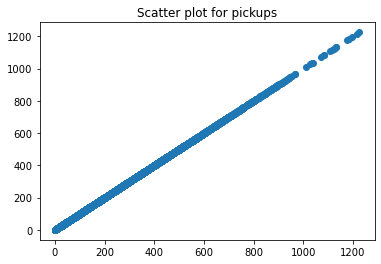

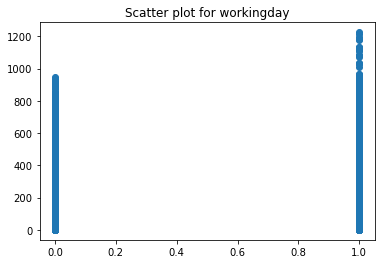

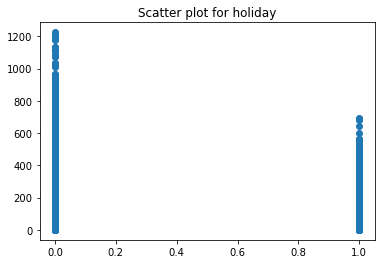

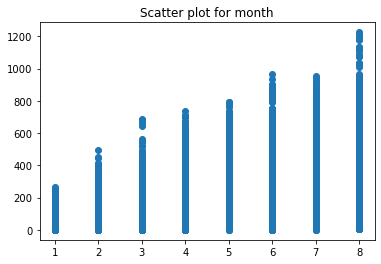

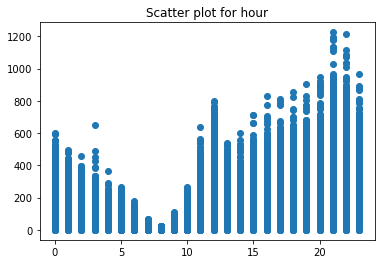

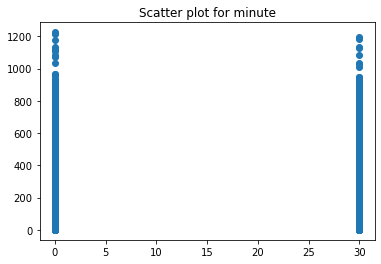

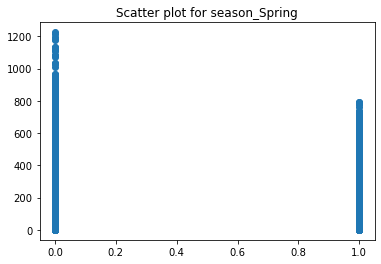

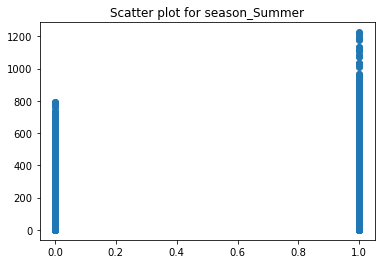

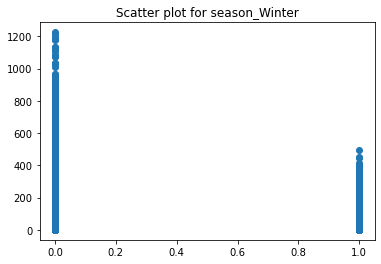

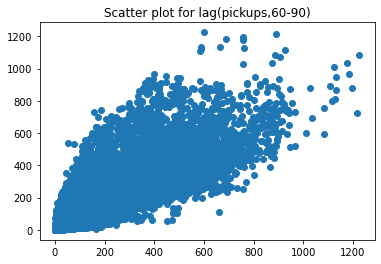

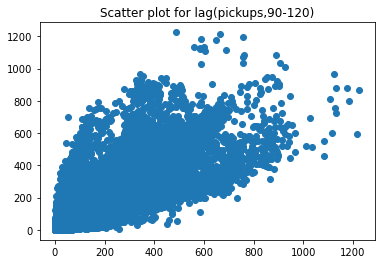

In [107]:
scatter_plot()

In [108]:
df30

,usertype_Customer,usertype_Subscriber,pickups
starttime,,,
2022-01-01 00:00:00,13.0,53.0,66.0
2022-01-01 00:30:00,15.0,44.0,59.0
2022-01-01 01:00:00,11.0,32.0,43.0
2022-01-01 01:30:00,20.0,29.0,49.0
2022-01-01 02:00:00,19.0,22.0,41.0
...,...,...,...
2022-08-31 21:30:00,130.0,1064.0,1194.0
2022-08-31 22:00:00,111.0,958.0,1069.0
2022-08-31 22:30:00,95.0,942.0,1037.0


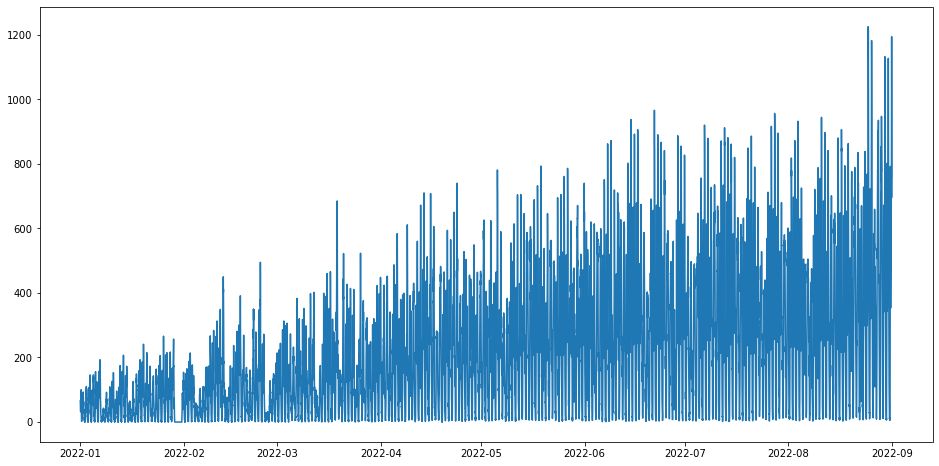

In [109]:
plt.figure(figsize=(16,8))
plt.plot(df30["pickups"])
plt.show()

<AxesSubplot:xlabel='hour', ylabel='pickups'>

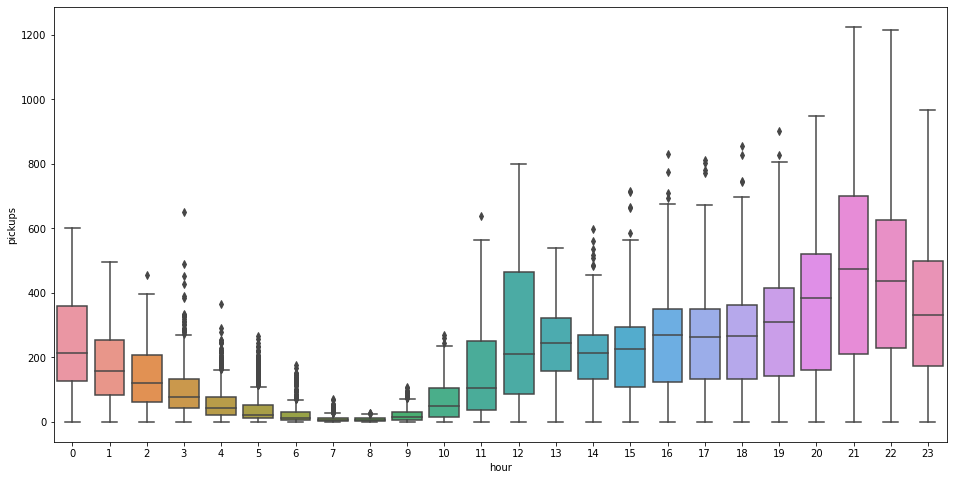

In [110]:
plt.figure(figsize=(16,8))
sns.boxplot(x='hour',y='pickups', data=picksup)

<AxesSubplot:xlabel='month', ylabel='pickups'>

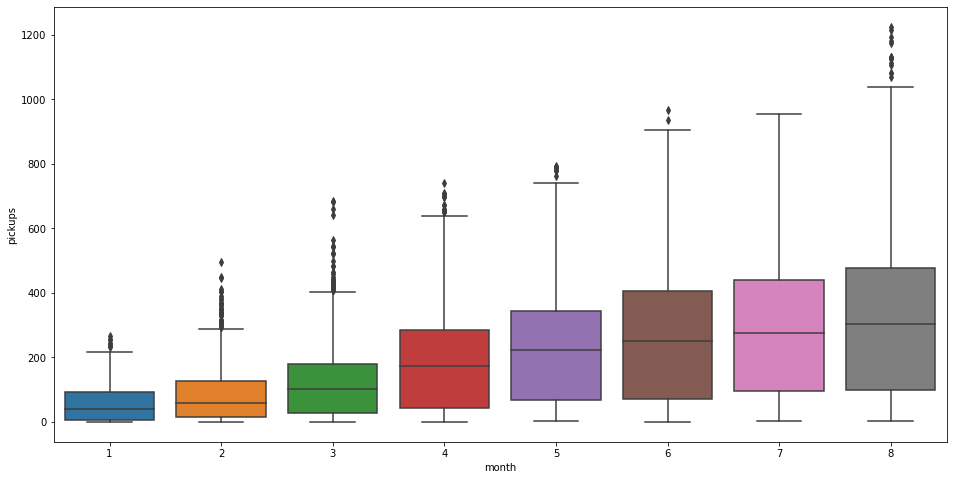

In [111]:
plt.figure(figsize=(16,8))
sns.boxplot(x='month',y='pickups', data=picksup)

<Figure size 1152x576 with 0 Axes>

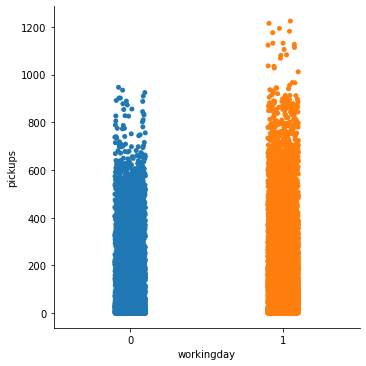

In [112]:
plt.figure(figsize=(16,8))
sns.catplot(data=picksup, x='workingday', y='pickups')

<Figure size 1152x576 with 0 Axes>

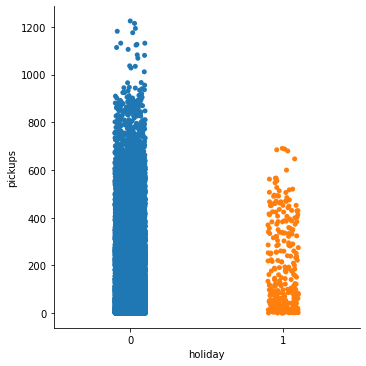

In [113]:
plt.figure(figsize=(16,8))
sns.catplot(data=picksup, x='holiday', y='pickups')

<AxesSubplot:xlabel='enc_conditions', ylabel='pickups'>

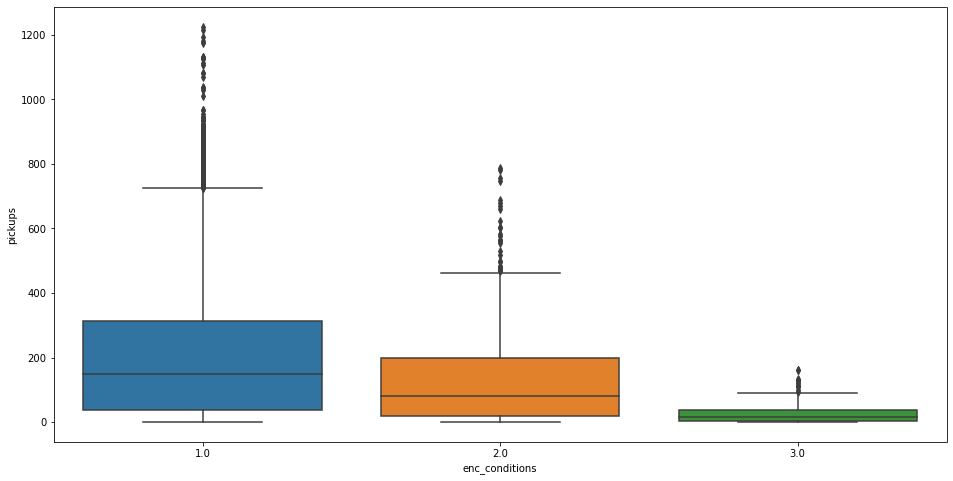

In [114]:
plt.figure(figsize=(16,8))
sns.boxplot(data=picksup, x='enc_conditions', y='pickups')

## MODELLING

In [115]:
picksup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11659 entries, 4 to 11662
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 11659 non-null  float64
 1   feelslike            11659 non-null  float64
 2   humidity             11659 non-null  float64
 3   precip               11659 non-null  float64
 4   snow                 11659 non-null  float64
 5   snowdepth            11659 non-null  float64
 6   windspeed            11659 non-null  float64
 7   visibility           11659 non-null  float64
 8   uvindex              11659 non-null  float64
 9   severerisk           11659 non-null  float64
 10  enc_preciptype       11659 non-null  float64
 11  enc_conditions       11659 non-null  float64
 12  usertype_Customer    11659 non-null  float64
 13  usertype_Subscriber  11659 non-null  float64
 14  pickups              11659 non-null  float64
 15  workingday           11659 non-null 

In [116]:
picksup.head()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,0,0,0,1,59.0,66.0
5,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,30,0,0,1,43.0,59.0
6,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,0,0,0,1,49.0,43.0
7,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,30,0,0,1,41.0,49.0
8,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,0,1,1,4,0,0,0,1,32.0,41.0


In [117]:
X = picksup.drop(['pickups','usertype_Subscriber','usertype_Customer','enc_preciptype','enc_conditions','precip','snow', 'feelslike', 'uvindex', 'severerisk'], axis=1)
y = picksup[['month','hour','pickups']]

In [118]:
X.head()

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,7.2,96.49,0.0,5.3,5.1,0,1,1,2,0,0,0,1,59.0,66.0
5,7.2,96.49,0.0,5.3,5.1,0,1,1,2,30,0,0,1,43.0,59.0
6,7.2,96.49,0.0,7.3,4.0,0,1,1,3,0,0,0,1,49.0,43.0
7,7.2,96.49,0.0,7.3,4.0,0,1,1,3,30,0,0,1,41.0,49.0
8,7.2,96.60,0.0,0.1,1.0,0,1,1,4,0,0,0,1,32.0,41.0


In [119]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
scaling_columns = ['temp', 'windspeed', 'humidity', 'snowdepth', 'visibility']
lag_columns = [c for c in X.columns if c.startswith("lag")]
X[scaling_columns+lag_columns] = sc_X.fit_transform(X[scaling_columns + lag_columns])

In [120]:
X.head()

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,0,0,0,1,-0.707038,-0.671528
5,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,30,0,0,1,-0.788751,-0.707317
6,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,0,0,0,1,-0.758109,-0.789119
7,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,30,0,0,1,-0.798966,-0.758443
8,-0.465538,1.685982,-0.375249,-2.030076,-3.913905,0,1,1,4,0,0,0,1,-0.844929,-0.799344


In [121]:
X[['workingday', 'holiday', 'month', 'hour', 'minute',
'season_Spring', 'season_Summer', 'season_Winter']] = X[['workingday', 'holiday', 'month', 'hour', 'minute',
                                                               'season_Spring', 'season_Summer', 'season_Winter']].astype('category')

In [122]:
X.head()

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,0,0,0,1,-0.707038,-0.671528
5,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,30,0,0,1,-0.788751,-0.707317
6,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,0,0,0,1,-0.758109,-0.789119
7,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,30,0,0,1,-0.798966,-0.758443
8,-0.465538,1.685982,-0.375249,-2.030076,-3.913905,0,1,1,4,0,0,0,1,-0.844929,-0.799344


In [134]:
X_train = X[X['month']!=8]
X_test = X[X['month']==8]
y_train = y[y['month']!=8]
y_test = y[y['month']==8]

In [135]:
X_train

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,0,0,0,1,-0.707038,-0.671528
5,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,30,0,0,1,-0.788751,-0.707317
6,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,0,0,0,1,-0.758109,-0.789119
7,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,30,0,0,1,-0.798966,-0.758443
8,-0.465538,1.685982,-0.375249,-2.030076,-3.913905,0,1,1,4,0,0,0,1,-0.844929,-0.799344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,1.397459,-1.257989,-0.375249,-0.171996,0.318904,0,0,7,21,30,0,1,0,1.861818,1.532026
10172,1.334153,-1.034002,-0.375249,-0.584903,0.318904,0,0,7,22,0,0,1,0,2.060994,1.864349
10173,1.334153,-1.034002,-0.375249,-0.584903,0.318904,0,0,7,22,30,0,1,0,1.943532,2.063742
10174,1.080930,-0.423353,-0.375249,-0.412858,0.318904,0,0,7,23,0,0,1,0,1.524752,1.946151


In [136]:
X.columns

Index(['temp', 'humidity', 'snowdepth', 'windspeed', 'visibility',
       'workingday', 'holiday', 'month', 'hour', 'minute', 'season_Spring',
       'season_Summer', 'season_Winter', 'lag(pickups,60-90)',
       'lag(pickups,90-120)'],
      dtype='object')

In [137]:
def FeaturesSelection(df):
    features_list = [
        'temp', 
        'humidity',
        'snowdepth',
        'windspeed',
        'visibility',
        'workingday',
        'holiday',
        'month',
        'hour',
         #'minute',
        'season_Spring',
        'season_Summer',
        'season_Winter',
        #'lag(pickups,60-75)',
        #'lag(pickups,75-90)',
        #'lag(pickups,90-105)',
        #'lag(pickups,105-120)'
        #'lag(pickups,60-90)',
        #'lag(pickups,90-120)'
        #'lag(pickups,60-120)',
       'lag(pickups,60-90)',
       'lag(pickups,90-120)'
    ]
    return df[features_list]

In [138]:
y_train

,month,hour,pickups
4,1,2,41.0
5,1,2,32.0
6,1,3,42.0
7,1,3,53.0
8,1,4,40.0
...,...,...,...
10171,7,21,496.0
10172,7,22,585.0
10173,7,22,521.0
10174,7,23,458.0


In [139]:
X_train.month.unique()

[1, 2, 3, 4, 5, 6, 7]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [154]:
# Back Testing
X_train = FeaturesSelection(X_train)
X_test = FeaturesSelection(X_test)

CV = []

LRM = Lasso()
for m in  X_train.month.unique()[:-1]:
    CV.append(m)
    xtemp_train = X_train[X_train['month'].isin(CV)]
    ytemp_train = y_train[y_train['month'].isin(CV)]['pickups']
    xtemp_test = X_train[X_train['month']==m+1]
    ytemp_test = y_train[y_train['month']==m+1]['pickups']
    
    LRM.fit(xtemp_train, ytemp_train)
    train_temp_preds = LRM.predict(xtemp_train)
    test_temp_preds = LRM.predict(xtemp_test)
    
    print('\nTrain Score: ',  LRM.score(xtemp_train, ytemp_train))
    print('Train RMSE : ',  np.sqrt(mean_squared_error(ytemp_train, train_temp_preds)))
    print('CV Score:    ',  LRM.score(xtemp_test, ytemp_test))
    print('CV MSE :    ',  np.sqrt(mean_squared_error(ytemp_test, test_temp_preds)))

LRM.fit(X_train, y_train['pickups'])          
print('\nFINAL')
print('Test Score: ', LRM.score(X_test, y_test['pickups']))
print('CV MSE :   ', np.sqrt(mean_squared_error(y_test['pickups'], LRM.predict(X_test))))


Train Score:  0.7784392130445563
Train RMSE :  24.901153624068463
CV Score:     0.7238958711176362
CV MSE :     42.2080966638027

Train Score:  0.7810808813287593
Train RMSE :  32.149887117165264
CV Score:     0.6873023456948419
CV MSE :     62.116775128775835

Train Score:  0.7556132195011378
Train RMSE :  44.28566287107488
CV Score:     0.7065288703574408
CV MSE :     84.42150176471158

Train Score:  0.7779034140160647
Train RMSE :  55.983811401075904
CV Score:     0.7073438121941
CV MSE :     98.51779800477483

Train Score:  0.7907420216640393
Train RMSE :  65.48721662012811
CV Score:     0.6791022551896555
CV MSE :     121.3581001170452

Train Score:  0.783204227518004
Train RMSE :  76.66666498784073
CV Score:     0.6905580416456145
CV MSE :     118.55205586514279

FINAL
Test Score:  0.7035471820197143
CV MSE :    138.30346126093247


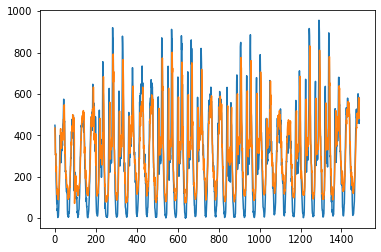

In [155]:
plt.plot(ytemp_test.values)
plt.plot(test_temp_preds)

In [156]:
ytemp_test

8688     449.0
8689     437.0
8690     398.0
8691     305.0
8692     311.0
         ...  
10171    496.0
10172    585.0
10173    521.0
10174    458.0
10175    472.0
Name: pickups, Length: 1488, dtype: float64

In [157]:
test_temp_preds

array([435.72363907, 391.92380696, 319.76571882, ..., 553.88465399,
       482.79065363, 575.06842478])